# Medical Image Classification

In [1]:
from tqdm import tqdm
import numpy as np
import os
import PIL
import shutil
import tempfile
import matplotlib.pyplot as plt
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report

import medmnist
from medmnist import INFO, Evaluator

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader, Dataset
from monai.metrics import ROCAUCMetric
import monai.networks.nets as nets
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    EnsureChannelFirst,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    RandGaussianNoise,
    RandAdjustContrast,
    Resize,
    ScaleIntensity, 
    Transform,
    ToTensor,
    EnsureType,
)
from monai.utils import set_determinism

print_config()

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.4.dev2441
Numpy version: 1.26.3
Pytorch version: 2.2.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: cf815ed4e44a5b8ce67e894ab0bc2765279a1a59
MONAI __file__: /mnt/hdd/<username>/.local/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: 0.24.0
scipy version: 1.14.1
Pillow version: 10.2.0
Tensorboard version: 2.18.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.17.1
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.2.3
einops version: 0.8.0
transformers version: 4.47.0
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the o

## Continue working with OrganMNIST3d 64x64x64

In [2]:
data_flag = 'organmnist3d'
download = True

NUM_EPOCHS = 100
BATCH_SIZE = 32
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download, size=64)
val_dataset = DataClass(split='val', download=download, size=64)
test_dataset = DataClass(split='test', download=download, size=64)

Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz
Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz
Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz


In [3]:
root_dir = '/mnt/hdd/marina/.medmnist/'

In [4]:
train_dataset

Dataset OrganMNIST3D of size 64 (organmnist3d_64)
    Number of datapoints: 971
    Root location: /mnt/hdd/marina/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'liver', '1': 'kidney-right', '2': 'kidney-left', '3': 'femur-right', '4': 'femur-left', '5': 'bladder', '6': 'heart', '7': 'lung-right', '8': 'lung-left', '9': 'spleen', '10': 'pancreas'}
    Number of samples: {'train': 971, 'val': 161, 'test': 610}
    Description: The source of the OrganMNIST3D is the same as that of the Organ{A,C,S}MNIST. Instead of 2D images, we directly use the 3D bounding boxes and process the images into 28×28×28 to perform multi-class classification of 11 body organs. The same 115 and 16 CT scans as the Organ{A,C,S}MNIST from the source training set are used as training and validation set, respectively, and the same 70 CT scans as the Organ{A,C,S}MNIST from the source test set are treated as the test set.
    License: CC BY 4.0

## Define transforms

In [5]:
train_transforms = Compose(
    [
        Resize((224, 224)),
        ScaleIntensity(),
        RandGaussianNoise(prob=0.5, mean=0.0, std=0.05),
        RandAdjustContrast(gamma=(0.7, 1.3), prob=0.5),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        ToTensor(),
        EnsureType(),
    ]
)

val_transforms = Compose([
    Resize((224, 224)),
    ScaleIntensity(),
    ToTensor(),
    EnsureType(),
])

test_transforms = Compose([
    Resize((224, 224)),
    ScaleIntensity(),
    ToTensor(),
    EnsureType(),
])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=n_classes)])

## Extract 2d slices

In [108]:
class Extract2DSlices(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data, label = self.dataset[idx]

        # if self.transform:
        #     data = self.transform(data)

        axial, coronal, sagittal = self.extract_2d_slices(data)

        if self.transform:
            axial = self.transform(axial)
            coronal = self.transform(coronal)
            sagittal = self.transform(sagittal)

        data = {'axial': axial, 'coronal': coronal, 'sagittal': sagittal}
        
        return {'images': (data['axial'], data['coronal'], data['sagittal']), 'label': label}

    @staticmethod
    def extract_2d_slices(data):
        mid_axial = data.shape[1] // 2
        mid_coronal = data.shape[2] // 2
        mid_sagittal = data.shape[3] // 2
        axial = data[:, mid_axial-1:mid_axial+2, :, :][0]
        coronal = data[:, :, mid_coronal-1:mid_coronal+2, :].transpose(0, 2, 3, 1)[0]
        sagittal = data[:, :, :, mid_sagittal-1:mid_sagittal+2].transpose(0, 3, 1, 2)[0]
        return axial, coronal, sagittal

In [109]:
train_dataset_ = Extract2DSlices(train_dataset, transform=train_transforms)
val_dataset_ = Extract2DSlices(val_dataset, transform=val_transforms)
test_dataset_ = Extract2DSlices(test_dataset, transform=test_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset_, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset_, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset_, batch_size=BATCH_SIZE, shuffle=False)

### Visualization

In [91]:
idx = np.random.choice(train_dataset_.__len__(), size=10, replace=False)

idx

array([166, 954, 471,  47, 111,  70, 321, 813, 552, 542])

In [78]:
def show_slice(dataset, idx):

    fig, axs = plt.subplots(3,10)

    for i, index in enumerate(idx):
        x1, x2, x3 = dataset[index]['images']
        y = dataset[index]['label']

        ax = axs[0, i]
        ax.imshow(x1[0].numpy(), cmap='gray')
        ax.set_title(f'{y}')
        ax.set_xticks([])
        ax.set_yticks([])

        ax = axs[1, i]
        ax.imshow(x2[0].numpy(), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

        ax = axs[2, i]
        ax.imshow(x3[0].numpy(), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

    plt.axis('off')
    plt.figure(figsize=(7,15))
    plt.show()

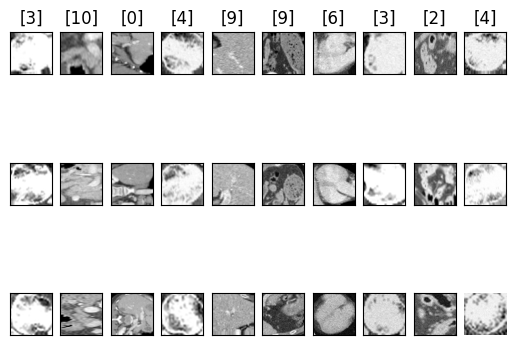

<Figure size 700x1500 with 0 Axes>

In [55]:
show_slice(train_dataset_, idx)

In [64]:
def montage(dataset, length=20, replace=False, save_folder='dataset', flag = 'axial'):
    from medmnist.utils import montage2d

    imgs = []

    n_sel = length * length
    sel = np.random.choice(dataset.__len__(), size=n_sel, replace=replace)
    
    if flag == 'axial':
        slice_ = 0
    elif flag == 'coronal':
        slice_ = 1
    else:
        slice_ = 2
    
    for idx in sel:
        imgs.append((dataset[idx]['images'][slice_][:, 1]*255).astype(np.uint8))
        
    montage_img = montage2d(np.array(imgs)[:, 0],
                            n_channels=n_channels,
                            sel=range(0, n_sel))
    
    if save_folder is not None:
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)
        montage_img.save(os.path.join(save_folder,
                                        f"{data_flag}{flag}_montage.png"))

    return montage_img

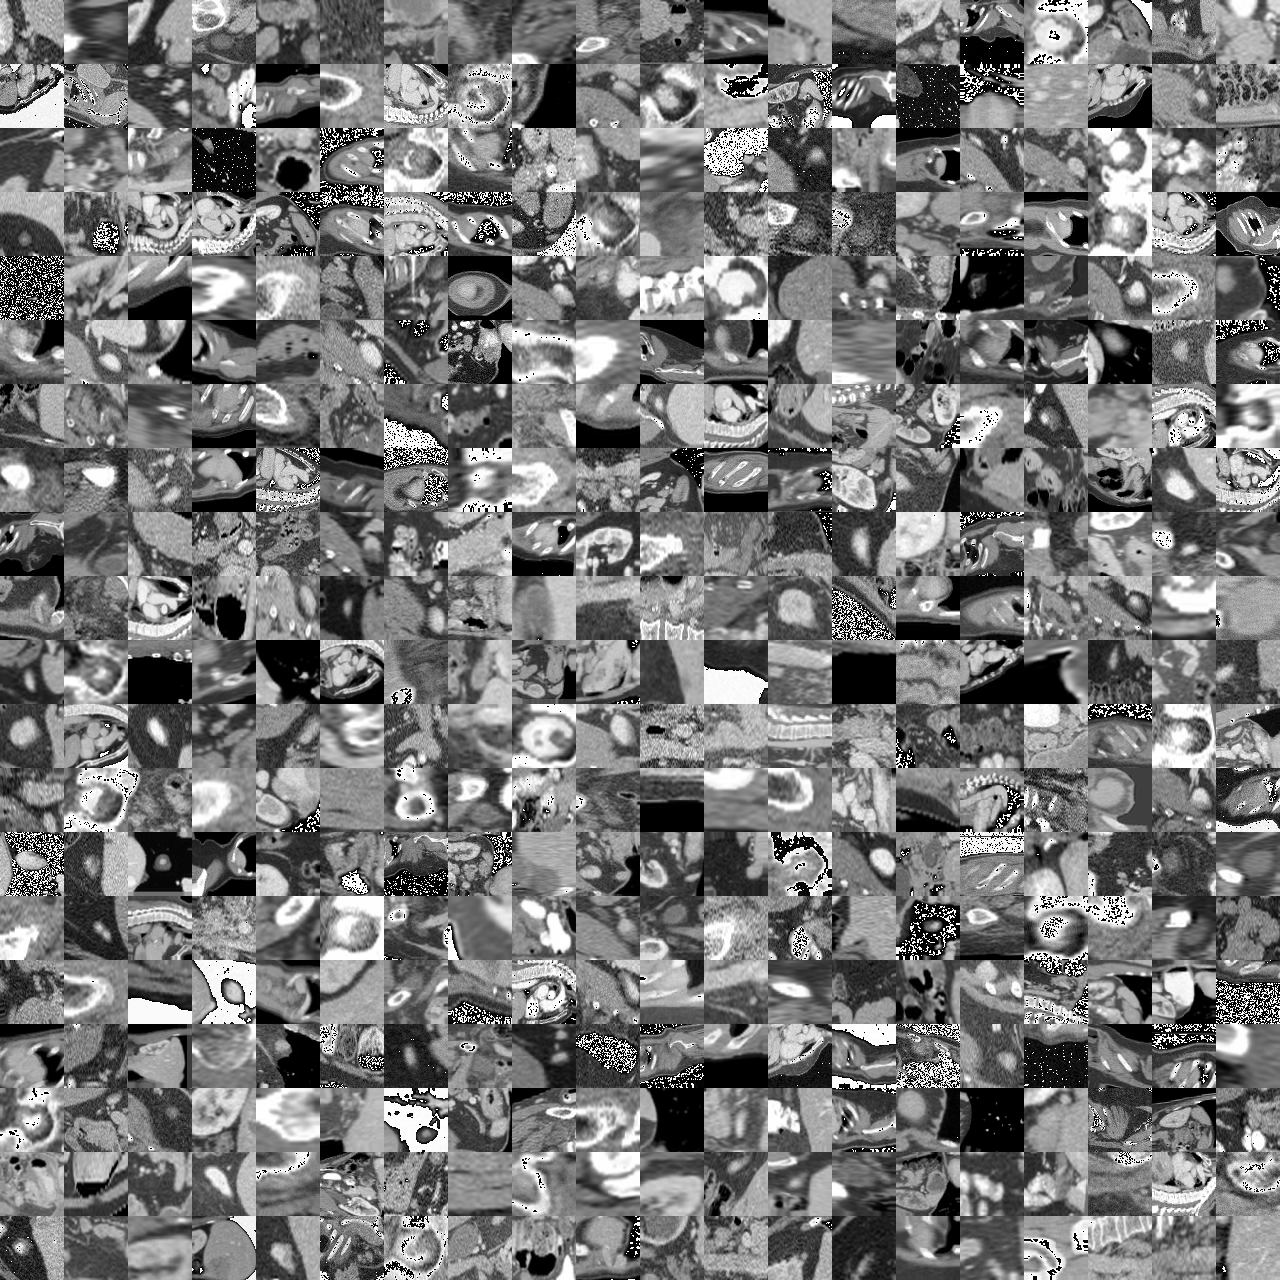

In [65]:
montage(train_dataset_, length=20, replace=False, flag = 'axial')

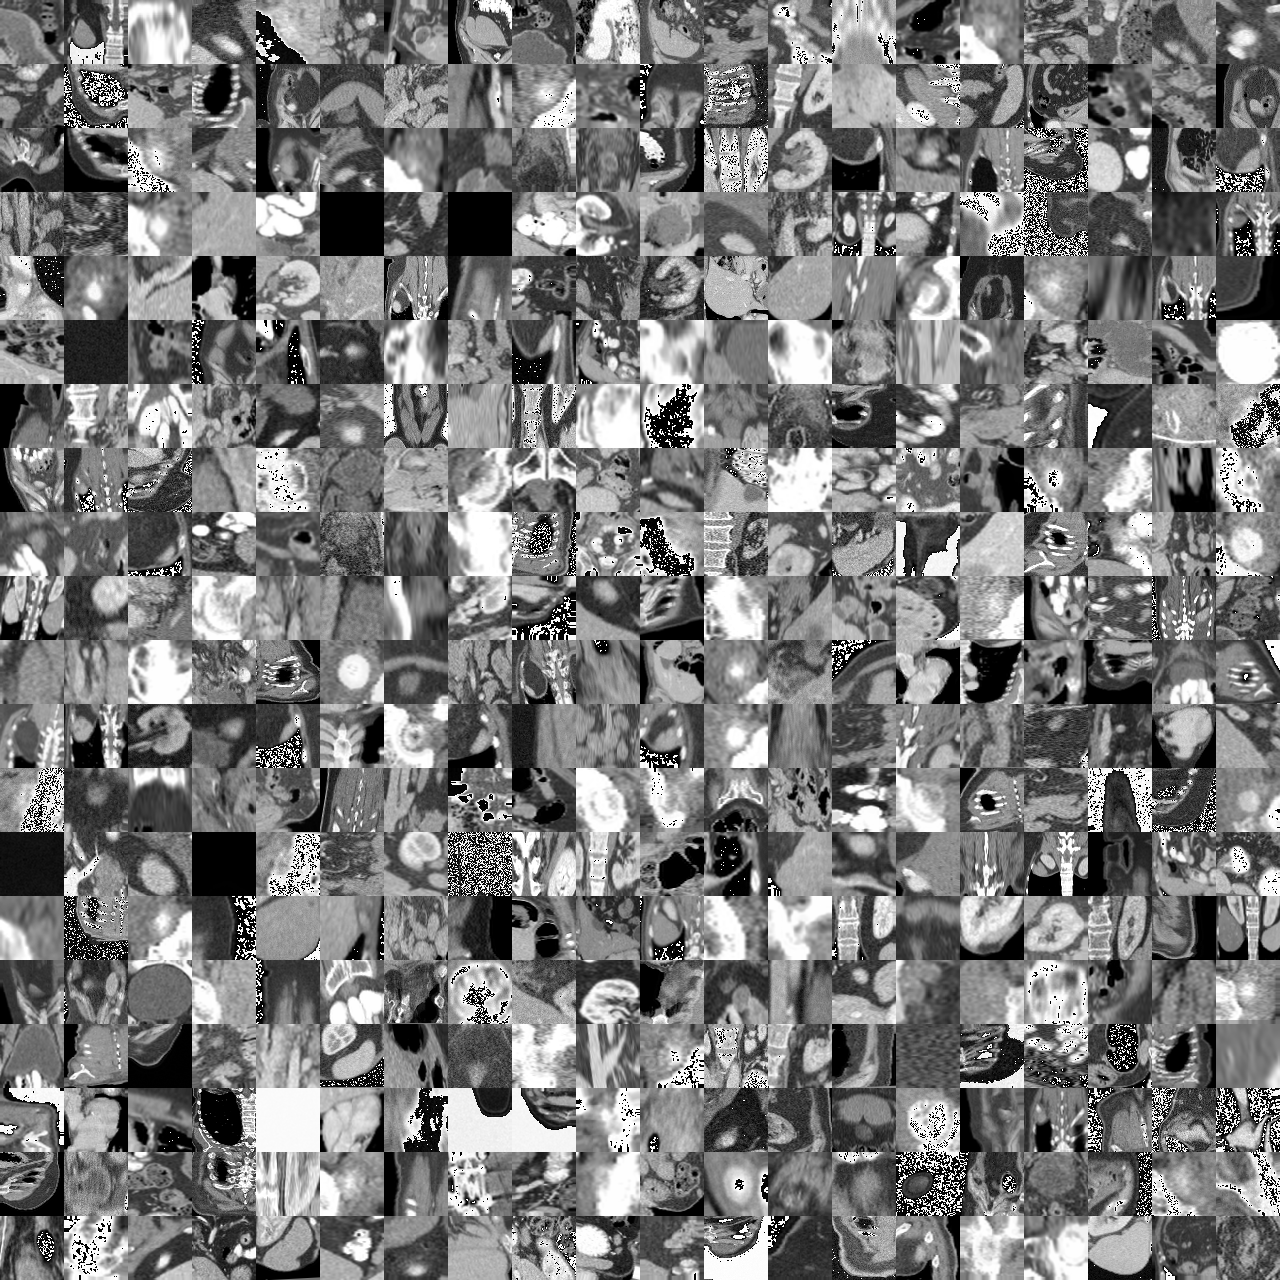

In [66]:
montage(train_dataset_, length=20, replace=False, flag = 'coronal')

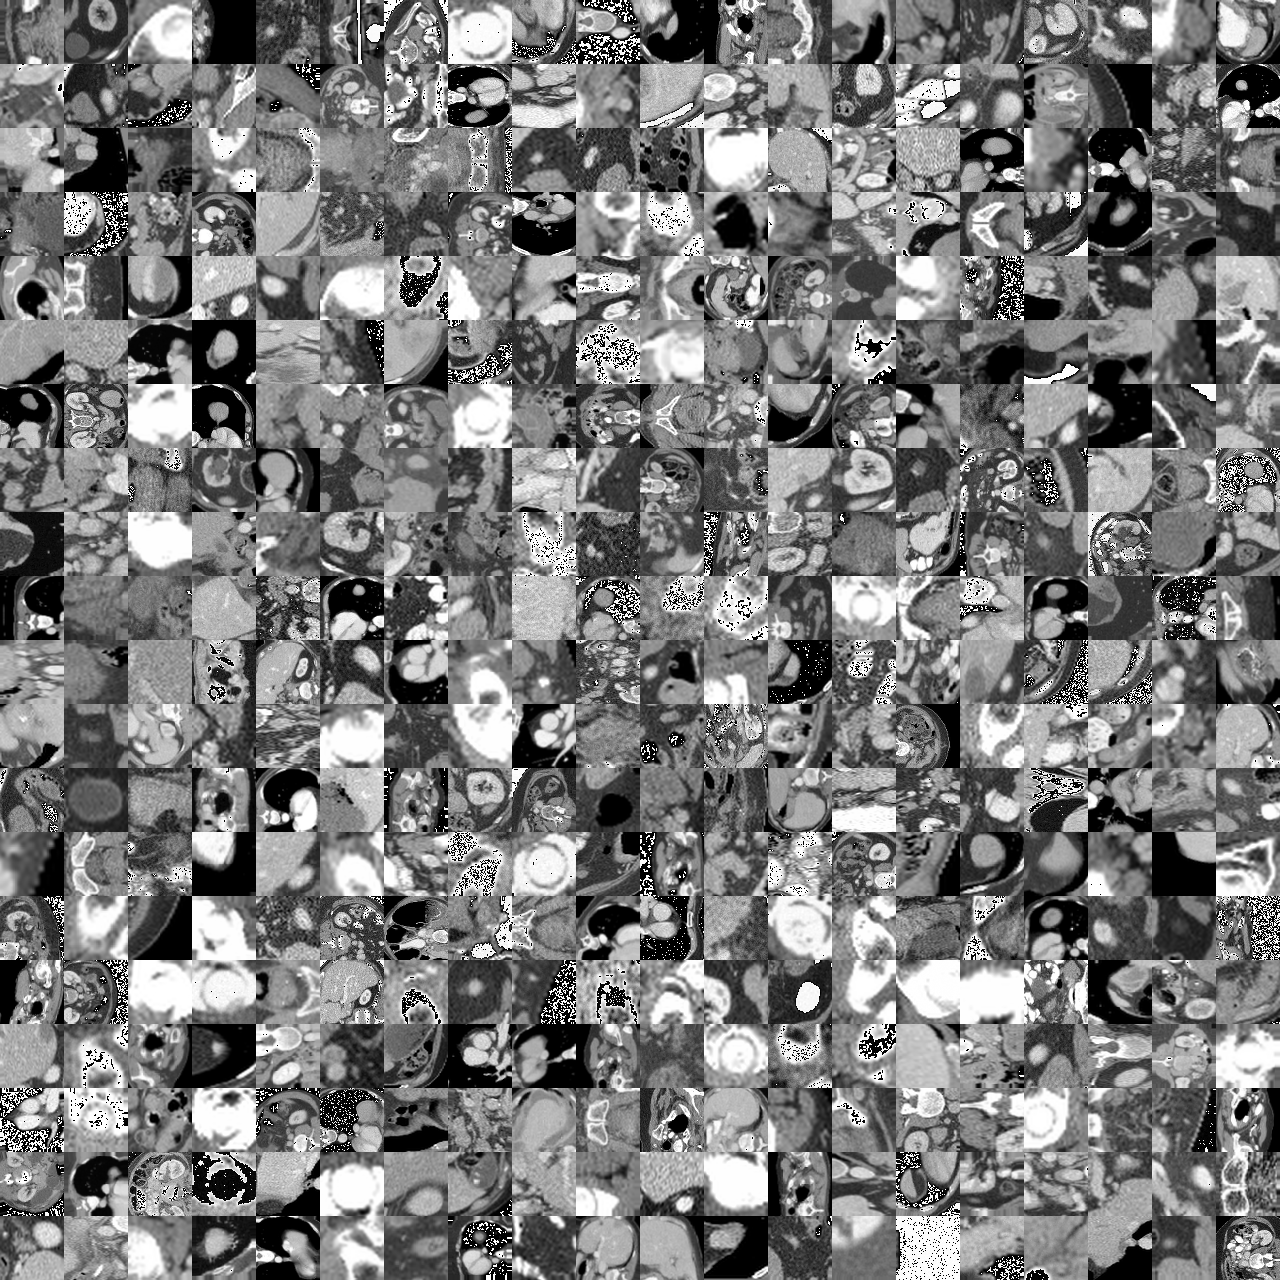

In [67]:
montage(train_dataset_, length=20, replace=False, flag = 'sagittal')

# Axial part

In [205]:
model_name = "google/vit-base-patch16-224"                        # the model name
image_processor = ViTImageProcessor.from_pretrained(model_name)   # load the image processor
model = ViTForImageClassification.from_pretrained(model_name) 

# load the ViT model
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=n_classes,
    ignore_mismatched_sizes=True,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([11]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([11, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [206]:
# defining the training arguments
training_args = TrainingArguments(
    # output_dir="./vit-base-food", # output directory
    output_dir=os.path.join(root_dir, "./vit-base-organs"),
    per_device_train_batch_size=32, # batch size per device during training
    eval_strategy="steps",    # evaluation strategy to adopt during training
    num_train_epochs=30,             # total number of training epochs
    # fp16=True,                    # use mixed precision
    # save_steps=374,                # number of update steps before saving checkpoint
    # eval_steps=374,                # number of update steps before evaluating
    # logging_steps=374,             # number of update steps before logging
    save_steps=50,
    eval_steps=50,
    logging_steps=50,
    save_total_limit=2,             # limit the total amount of checkpoints on disk
    remove_unused_columns=False,    # remove unused columns from the dataset
    push_to_hub=False,              # do not push the model to the hub
    report_to='tensorboard',        # report metrics to tensorboard
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,    # load the best model at the end of training
)

In [207]:
def collate_fn(batch):
  return {
      "pixel_values": torch.stack([x["images"][0] for x in batch]),
      "labels": torch.tensor([x["label"] for x in batch]),
  }

In [208]:
from evaluate import load

# load the accuracy and f1 metrics from the evaluate module
accuracy = load("accuracy")
f1 = load("f1")

def compute_metrics(eval_pred):
  # compute the accuracy and f1 scores & return them
  accuracy_score = accuracy.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids)
  f1_score = f1.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids, average="macro")
  return {**accuracy_score, **f1_score}

In [209]:
# Create Trainer
from transformers import Trainer

trainer = Trainer(
    model=model,                        # the instantiated 🤗 Transformers model to be trained
    args=training_args,                 # training arguments, defined above
    data_collator=collate_fn,           # the data collator that will be used for batching
    compute_metrics=compute_metrics,    # the metrics function that will be used for evaluation
    train_dataset=train_dataset_,     # training dataset
    eval_dataset=val_dataset_, # evaluation dataset
    tokenizer=image_processor,          # the processor that will be used for preprocessing the images
)

/tmp/ipykernel_366/3286711356.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [210]:
trainer.train()

TrainOutput(global_step=930, training_loss=0.11805994380666043, metrics={'train_runtime': 1263.8754, 'train_samples_per_second': 23.048, 'train_steps_per_second': 0.736, 'total_flos': 2.2575237440265216e+18, 'train_loss': 0.11805994380666043, 'epoch': 30.0})

In [211]:
best_model_path = os.path.join(root_dir, "./vit-base-organs/best_metric_model_axial.pth")
trainer.save_model(best_model_path)

In [212]:
trainer.evaluate(test_dataset_)

{'eval_loss': 0.5142496824264526,
 'eval_accuracy': 0.8344262295081967,
 'eval_f1': 0.8602234354756362,
 'eval_runtime': 8.826,
 'eval_samples_per_second': 69.114,
 'eval_steps_per_second': 8.724,
 'epoch': 30.0}

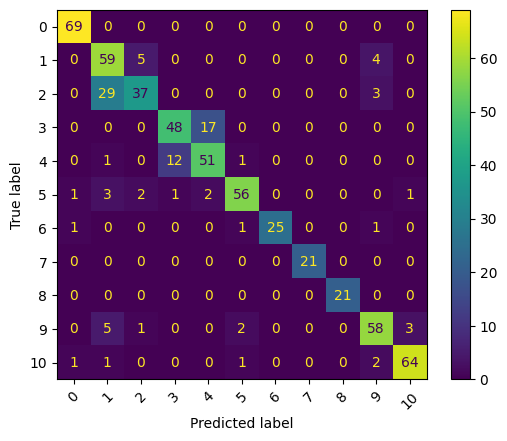

In [213]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

outputs = trainer.predict(test_dataset_)
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

# labels = test_dataset_['label']
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [214]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred, average=None)
precision, recall, f1_score, support

(array([0.95833333, 0.60204082, 0.82222222, 0.78688525, 0.72857143,
        0.91803279, 1.        , 1.        , 1.        , 0.85294118,
        0.94117647]),
 array([1.        , 0.86764706, 0.53623188, 0.73846154, 0.78461538,
        0.84848485, 0.89285714, 1.        , 1.        , 0.84057971,
        0.92753623]),
 array([0.9787234 , 0.71084337, 0.64912281, 0.76190476, 0.75555556,
        0.88188976, 0.94339623, 1.        , 1.        , 0.84671533,
        0.93430657]),
 array([69, 68, 69, 65, 65, 66, 28, 21, 21, 69, 69]))

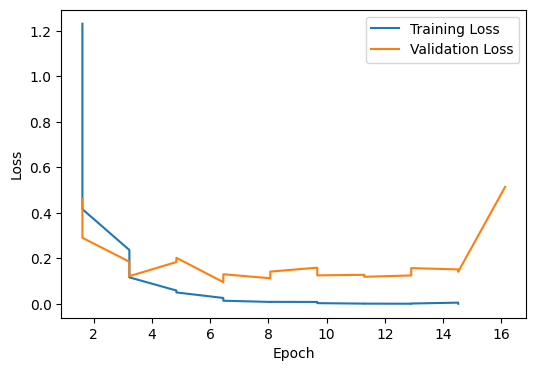

In [215]:
import matplotlib.pyplot as plt

data = trainer.state.log_history
# Extracting data for plotting
epochs = [entry['epoch'] for entry in data]  # Extract epoch values
train_losses = [entry['loss'] for entry in data if 'loss' in entry]  # Extract training losses
eval_losses = [entry['eval_loss'] for entry in data if 'eval_loss' in entry]  # Extract evaluation losses

# Plotting training and evaluation metrics
plt.figure(figsize=(6, 4))

plt.plot(epochs[:len(train_losses)], train_losses, label='Training Loss')
plt.plot(epochs[:len(eval_losses)], eval_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.title('Training and Evaluation Metrics Across Epochs')
plt.legend()
# plt.grid(True)
plt.show()

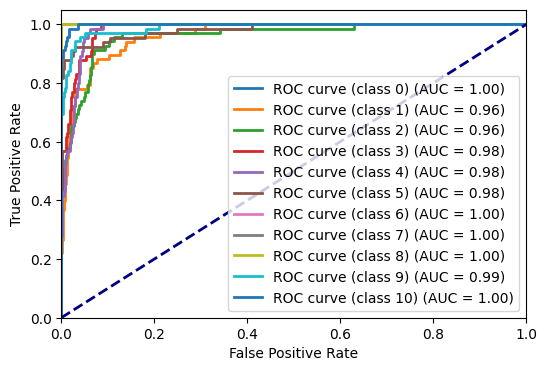

In [216]:
from sklearn.metrics import roc_curve, auc

# Assuming you have predictions and true labels for multi-class classification
# predictions shape: (num_samples, num_classes), where each row contains class probabilities
# true_labels shape: (num_samples,), where each value represents the true class label
true_labels = outputs.label_ids
predictions = outputs.predictions

# Compute ROC curve for each class
num_classes = predictions.shape[1]  # Number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve((true_labels == i).astype(int), predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(6, 4))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (class %d) (AUC = %0.2f)' % (i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Coronal and sagittal parts

## Training cycle for the coronal part

In [164]:
model_name = "google/vit-base-patch16-224"                        # the model name
image_processor = ViTImageProcessor.from_pretrained(model_name)   # load the image processor
model = ViTForImageClassification.from_pretrained(model_name) 

# load the ViT model
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=n_classes,
    ignore_mismatched_sizes=True,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([11]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([11, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [171]:
# defining the training arguments
training_args = TrainingArguments(
    # output_dir="./vit-base-food", # output directory
    output_dir=os.path.join(root_dir, "./vit-base-organs"),
    per_device_train_batch_size=32, # batch size per device during training
    eval_strategy="steps",    # evaluation strategy to adopt during training
    num_train_epochs=30,             # total number of training epochs
    # fp16=True,                    # use mixed precision
    # save_steps=374,                # number of update steps before saving checkpoint
    # eval_steps=374,                # number of update steps before evaluating
    # logging_steps=374,             # number of update steps before logging
    save_steps=50,
    eval_steps=50,
    logging_steps=50,
    save_total_limit=2,             # limit the total amount of checkpoints on disk
    remove_unused_columns=False,    # remove unused columns from the dataset
    push_to_hub=False,              # do not push the model to the hub
    report_to='tensorboard',        # report metrics to tensorboard
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,    # load the best model at the end of training
)

In [172]:
def collate_fn(batch):
  return {
      "pixel_values": torch.stack([x["images"][1] for x in batch]),
      "labels": torch.tensor([x["label"] for x in batch]),
  }

In [173]:
from evaluate import load

# load the accuracy and f1 metrics from the evaluate module
accuracy = load("accuracy")
f1 = load("f1")

def compute_metrics(eval_pred):
  # compute the accuracy and f1 scores & return them
  accuracy_score = accuracy.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids)
  f1_score = f1.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids, average="macro")
  return {**accuracy_score, **f1_score}

In [174]:
# Create Trainer
from transformers import Trainer

trainer = Trainer(
    model=model,                        # the instantiated 🤗 Transformers model to be trained
    args=training_args,                 # training arguments, defined above
    data_collator=collate_fn,           # the data collator that will be used for batching
    compute_metrics=compute_metrics,    # the metrics function that will be used for evaluation
    train_dataset=train_dataset_,     # training dataset
    eval_dataset=val_dataset_, # evaluation dataset
    tokenizer=image_processor,          # the processor that will be used for preprocessing the images
)

/tmp/ipykernel_366/3286711356.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [175]:
trainer.train()

TrainOutput(global_step=930, training_loss=0.11672494047952275, metrics={'train_runtime': 1266.1344, 'train_samples_per_second': 23.007, 'train_steps_per_second': 0.735, 'total_flos': 2.2575237440265216e+18, 'train_loss': 0.11672494047952275, 'epoch': 30.0})

In [176]:
best_model_path = os.path.join(root_dir, "./vit-base-organs/best_metric_model_coronal.pth")
trainer.save_model(best_model_path)

In [177]:
trainer.evaluate(test_dataset_)

{'eval_loss': 0.26255732774734497,
 'eval_accuracy': 0.9147540983606557,
 'eval_f1': 0.9276139123016957,
 'eval_runtime': 8.9589,
 'eval_samples_per_second': 68.089,
 'eval_steps_per_second': 8.595,
 'epoch': 30.0}

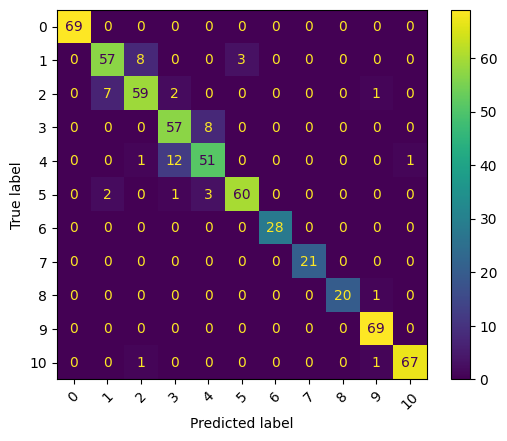

In [178]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

outputs = trainer.predict(test_dataset_)
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

# labels = test_dataset_['label']
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [179]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred, average=None)
precision, recall, f1_score, support

(array([1.        , 0.86363636, 0.85507246, 0.79166667, 0.82258065,
        0.95238095, 1.        , 1.        , 1.        , 0.95833333,
        0.98529412]),
 array([1.        , 0.83823529, 0.85507246, 0.87692308, 0.78461538,
        0.90909091, 1.        , 1.        , 0.95238095, 1.        ,
        0.97101449]),
 array([1.        , 0.85074627, 0.85507246, 0.83211679, 0.80314961,
        0.93023256, 1.        , 1.        , 0.97560976, 0.9787234 ,
        0.97810219]),
 array([69, 68, 69, 65, 65, 66, 28, 21, 21, 69, 69]))

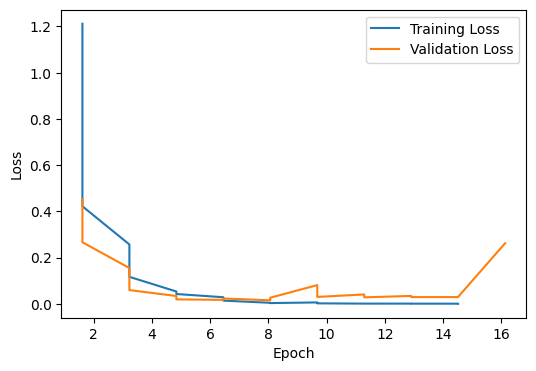

In [180]:
import matplotlib.pyplot as plt

data = trainer.state.log_history
# Extracting data for plotting
epochs = [entry['epoch'] for entry in data]  # Extract epoch values
train_losses = [entry['loss'] for entry in data if 'loss' in entry]  # Extract training losses
eval_losses = [entry['eval_loss'] for entry in data if 'eval_loss' in entry]  # Extract evaluation losses

# Plotting training and evaluation metrics
plt.figure(figsize=(6, 4))

plt.plot(epochs[:len(train_losses)], train_losses, label='Training Loss')
plt.plot(epochs[:len(eval_losses)], eval_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.title('Training and Evaluation Metrics Across Epochs')
plt.legend()
# plt.grid(True)
plt.show()

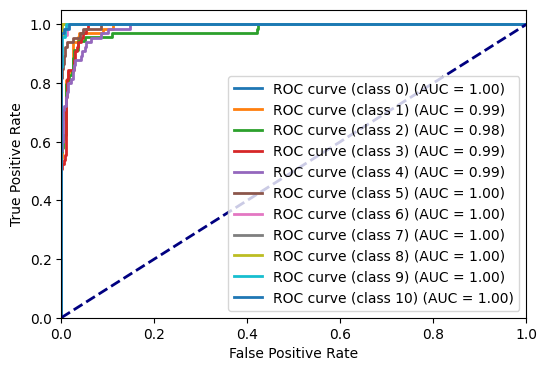

In [181]:

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have predictions and true labels for multi-class classification
# predictions shape: (num_samples, num_classes), where each row contains class probabilities
# true_labels shape: (num_samples,), where each value represents the true class label
true_labels = outputs.label_ids
predictions = outputs.predictions

# Compute ROC curve for each class
num_classes = predictions.shape[1]  # Number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve((true_labels == i).astype(int), predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(6, 4))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (class %d) (AUC = %0.2f)' % (i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

## Training cycle for the sagittal part

In [182]:
model_name = "google/vit-base-patch16-224"                        # the model name
image_processor = ViTImageProcessor.from_pretrained(model_name)   # load the image processor
model = ViTForImageClassification.from_pretrained(model_name) 

# load the ViT model
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=n_classes,
    ignore_mismatched_sizes=True,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([11]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([11, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [183]:
# defining the training arguments
training_args = TrainingArguments(
    # output_dir="./vit-base-food", # output directory
    output_dir=os.path.join(root_dir, "./vit-base-organs"),
    per_device_train_batch_size=32, # batch size per device during training
    eval_strategy="steps",    # evaluation strategy to adopt during training
    num_train_epochs=30,             # total number of training epochs
    # fp16=True,                    # use mixed precision
    # save_steps=374,                # number of update steps before saving checkpoint
    # eval_steps=374,                # number of update steps before evaluating
    # logging_steps=374,             # number of update steps before logging
    save_steps=50,
    eval_steps=50,
    logging_steps=50,
    save_total_limit=2,             # limit the total amount of checkpoints on disk
    remove_unused_columns=False,    # remove unused columns from the dataset
    push_to_hub=False,              # do not push the model to the hub
    report_to='tensorboard',        # report metrics to tensorboard
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,    # load the best model at the end of training
)

In [184]:
def collate_fn(batch):
  return {
      "pixel_values": torch.stack([x["images"][2] for x in batch]),
      "labels": torch.tensor([x["label"] for x in batch]),
  }

In [185]:
from evaluate import load

# load the accuracy and f1 metrics from the evaluate module
accuracy = load("accuracy")
f1 = load("f1")

def compute_metrics(eval_pred):
  # compute the accuracy and f1 scores & return them
  accuracy_score = accuracy.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids)
  f1_score = f1.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids, average="macro")
  return {**accuracy_score, **f1_score}

In [186]:
# Create Trainer
from transformers import Trainer

trainer = Trainer(
    model=model,                        # the instantiated 🤗 Transformers model to be trained
    args=training_args,                 # training arguments, defined above
    data_collator=collate_fn,           # the data collator that will be used for batching
    compute_metrics=compute_metrics,    # the metrics function that will be used for evaluation
    train_dataset=train_dataset_,     # training dataset
    eval_dataset=val_dataset_, # evaluation dataset
    tokenizer=image_processor,          # the processor that will be used for preprocessing the images
)

/tmp/ipykernel_366/3286711356.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [187]:
trainer.train()

TrainOutput(global_step=930, training_loss=0.1626291893582831, metrics={'train_runtime': 1259.6401, 'train_samples_per_second': 23.126, 'train_steps_per_second': 0.738, 'total_flos': 2.2575237440265216e+18, 'train_loss': 0.1626291893582831, 'epoch': 30.0})

In [188]:
best_model_path = os.path.join(root_dir, "./vit-base-organs/best_metric_model_sagittal.pth")
trainer.save_model(best_model_path)

In [189]:
trainer.evaluate(test_dataset_)

{'eval_loss': 0.5966655611991882,
 'eval_accuracy': 0.7819672131147541,
 'eval_f1': 0.8034054149183087,
 'eval_runtime': 8.8037,
 'eval_samples_per_second': 69.289,
 'eval_steps_per_second': 8.746,
 'epoch': 30.0}

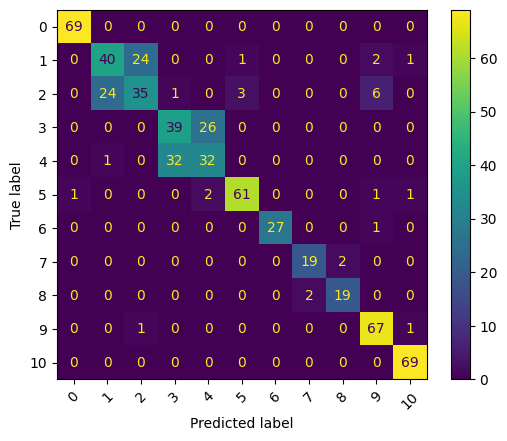

In [190]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

outputs = trainer.predict(test_dataset_)
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

# labels = test_dataset_['label']
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [191]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred, average=None)
precision, recall, f1_score, support

(array([0.98571429, 0.61538462, 0.58333333, 0.54166667, 0.53333333,
        0.93846154, 1.        , 0.9047619 , 0.9047619 , 0.87012987,
        0.95833333]),
 array([1.        , 0.58823529, 0.50724638, 0.6       , 0.49230769,
        0.92424242, 0.96428571, 0.9047619 , 0.9047619 , 0.97101449,
        1.        ]),
 array([0.99280576, 0.60150376, 0.54263566, 0.56934307, 0.512     ,
        0.93129771, 0.98181818, 0.9047619 , 0.9047619 , 0.91780822,
        0.9787234 ]),
 array([69, 68, 69, 65, 65, 66, 28, 21, 21, 69, 69]))

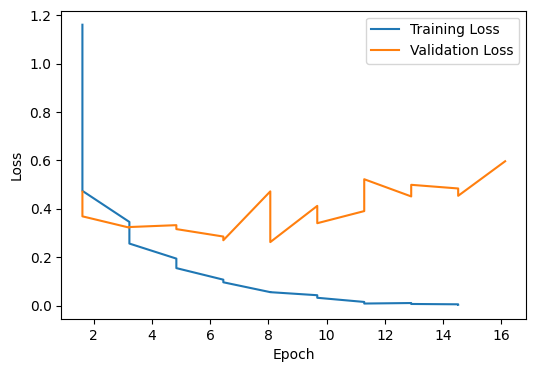

In [192]:
import matplotlib.pyplot as plt

data = trainer.state.log_history
# Extracting data for plotting
epochs = [entry['epoch'] for entry in data]  # Extract epoch values
train_losses = [entry['loss'] for entry in data if 'loss' in entry]  # Extract training losses
eval_losses = [entry['eval_loss'] for entry in data if 'eval_loss' in entry]  # Extract evaluation losses

# Plotting training and evaluation metrics
plt.figure(figsize=(6, 4))

plt.plot(epochs[:len(train_losses)], train_losses, label='Training Loss')
plt.plot(epochs[:len(eval_losses)], eval_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.title('Training and Evaluation Metrics Across Epochs')
plt.legend()
# plt.grid(True)
plt.show()

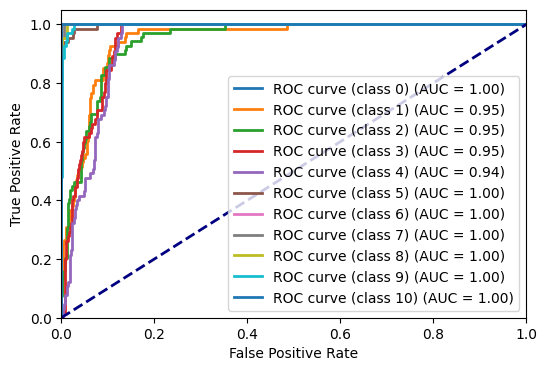

In [193]:
from sklearn.metrics import roc_curve, auc

# Assuming you have predictions and true labels for multi-class classification
# predictions shape: (num_samples, num_classes), where each row contains class probabilities
# true_labels shape: (num_samples,), where each value represents the true class label
true_labels = outputs.label_ids
predictions = outputs.predictions

# Compute ROC curve for each class
num_classes = predictions.shape[1]  # Number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve((true_labels == i).astype(int), predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(6, 4))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (class %d) (AUC = %0.2f)' % (i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# 3D slices evaluation

In [246]:
class Sliced_Dataset(Dataset):
    def __init__(self, dataset, slices=21, transform=None):
        self.dataset = dataset
        self.slices = slices
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data, label = self.dataset[idx]
        slices = self.slices

        # if self.transform:
        #     data = self.transform(data)

        axial, coronal, sagittal = self.get_middle_slices(data, slices)

        if self.transform:
            axial = self.transform(axial)
            coronal = self.transform(coronal)
            sagittal = self.transform(sagittal)

        data = {'axial': axial, 'coronal': coronal, 'sagittal': sagittal}
        
        return {'images': (data['axial'], data['coronal'], data['sagittal']), 'label': label}

    @staticmethod
    def get_middle_slices(data, slices):
        dims = data.shape
        axial, coronal, sagittal = [], [], []
        middle_idx = [dims[i] // 2 for i in range(1, 4)]
        
        for d in range(3):  # 0 - Axial, 1 - Coronal, 2 - Sagittal
            start_idx = middle_idx[d] - slices // 2  # Start 4 slices before the middle
            end_idx = middle_idx[d] + slices // 2 + 1    # End 4 slices after the middle
            
            for i in range(start_idx, end_idx, 3):
                if d == 0:
                    axial.append(data[:, i:i+3, :, :][0])
                elif d == 1:
                    coronal.append(data[:, :, i:i+3, :].transpose(0, 2, 3, 1)[0])
                elif d == 2:
                    sagittal.append(data[:, :, :, i:i+3].transpose(0, 3, 1, 2)[0])
        
        return axial, coronal, sagittal

In [247]:
train_dataset_ = Sliced_Dataset(train_dataset, transform=train_transforms)
val_dataset_ = Sliced_Dataset(val_dataset, transform=val_transforms)
test_dataset_ = Sliced_Dataset(test_dataset, transform=test_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset_, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset_, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset_, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
from transformers import AutoModelForImageClassification, AutoTokenizer

# Load the model
model_axial = AutoModelForImageClassification.from_pretrained(
    os.path.join(root_dir, "./vit-base-organs/best_metric_model_axial.pth")).to(device)
model_axial.eval()
model_coronal = AutoModelForImageClassification.from_pretrained(
    os.path.join(root_dir, "./vit-base-organs/best_metric_model_coronal.pth")).to(device)
model_coronal.eval()
model_sagittal = AutoModelForImageClassification.from_pretrained(
    os.path.join(root_dir, "./vit-base-organs/best_metric_model_sagittal.pth")).to(device)
model_sagittal.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [257]:
y_true = []
y_pred = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images

        for i in range(7):
            pred_axial = model_axial(test_axial[i].to(device)).logits.argmax(dim=1)
            pred_coronal = model_coronal(test_coronal[i].to(device)).logits.argmax(dim=1)
            pred_sagittal = model_sagittal(test_sagittal[i].to(device)).logits.argmax(dim=1)
            if i != 0:
                pred = torch.cat((pred, torch.stack((pred_axial, pred_coronal, pred_sagittal), axis = 0)))
            else:
                pred = torch.stack((pred_axial, pred_coronal, pred_sagittal), axis = 0)
        
        for i in range(pred.shape[1]):  # Iterate over batch
            data = pred[:, i]
            counts = torch.bincount(data)
            most_frequent_value = torch.argmax(counts).item()
            
            y_true.append(test_labels[i].item())
            y_pred.append(most_frequent_value)

In [258]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        69
           1     0.7403    0.8382    0.7862        68
           2     0.7931    0.6667    0.7244        69
           3     0.8125    0.8000    0.8062        65
           4     0.7826    0.8308    0.8060        65
           5     1.0000    0.9545    0.9767        66
           6     1.0000    1.0000    1.0000        28
           7     1.0000    1.0000    1.0000        21
           8     1.0000    1.0000    1.0000        21
           9     0.9583    1.0000    0.9787        69
          10     1.0000    0.9855    0.9927        69

    accuracy                         0.8984       610
   macro avg     0.9170    0.9160    0.9155       610
weighted avg     0.8998    0.8984    0.8979       610

